### Measure the scarlet vanilla model structures for LSBGs at 0.02 < z < 0.04

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.convolution import convolve, Gaussian2DKernel

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [4]:
lsbg_cat = Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
lsbg = lsbg_cat[np.where(lsbg_cat['viz-id'] == 35129)[0]][0]

In [6]:
with open(f"./Model/nsa_z002_004/vanilla/nsa-{lsbg['viz-id']}-trained-model-vanilla.df", "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

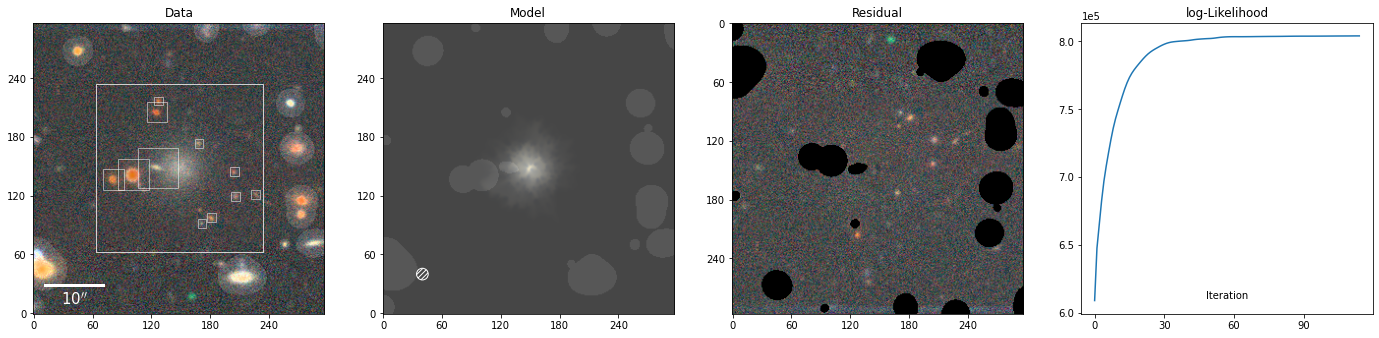

In [7]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            mask,
            show_ind=info['sed_ind'], #[0, 1],
            zoomin_size=50,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=blend.observations[0].channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

In [8]:
info['sed_ind']

array([0])

In [9]:
import statmorph

In [10]:
components = list(np.array(blend.sources)[info['sed_ind']])
observation = blend.observations[0]
aggr_mask = mask.astype(bool)

In [11]:
min_cutout_size = max([comp.bbox.shape[1] for comp in components])
# Multi-components enabled
_blend = scarlet.Blend(components, observation)
lower_left = np.min([np.array(comp.bbox.origin)
                    for comp in components], axis=0)
upper_right = np.max([np.array(comp.bbox.origin) +
                     np.array(comp.bbox.shape) for comp in components], axis=0)
bbox = scarlet.Box(upper_right - lower_left, origin=lower_left)
bbox.center = np.array(bbox.origin) + np.array(bbox.shape) // 2
bbox.shape = tuple(int(i * 1.5) for i in bbox.shape)
bbox.origin = tuple(bbox.center[i] - bbox.shape[i] // 2 for i in range(3))

models = _blend.get_model()  # PSF-free model
models = observation.render(models)  # PSF-convoled model
models = models[:, bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
                bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
data = observation.data
weights = observation.weights
psfs = observation.psf.get_model()
if aggr_mask is None:
    mask = (weights.sum(axis=0) == 0)
else:
    mask = aggr_mask | (weights.sum(axis=0) == 0)

data = data[:, bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
            bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
data = np.ascontiguousarray(data)
mask = mask[bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
            bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
mask = np.ascontiguousarray(mask)
weights = weights[:, bbox.origin[1]:bbox.origin[1] +
                  bbox.shape[1], bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
weights = np.ascontiguousarray(weights)

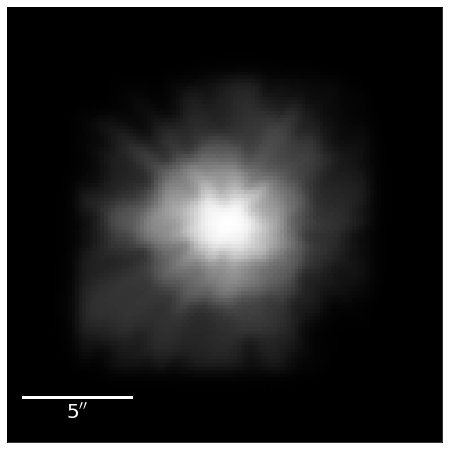

In [12]:
display_single(models[0], scale='linear', cmap='Greys_r');

In [13]:
# Flux and magnitude in each band
measure_dict = {}
measure_dict['flux'] = kz.measure.flux(components, observation)
# normalized against g-band
SED = (measure_dict['flux'] / measure_dict['flux'][0])
measure_dict['mag'] = -2.5 * np.log10(measure_dict['flux']) + 27.0

In [14]:
filt = 0
img = models[filt]
data_avg = np.average(data, weights=np.sqrt(weights.sum(axis=(1, 2))), axis=0)

In [15]:
sigma = 1

In [16]:
bkg = sep.Background(data_avg, bh=12, bw=12, mask=mask)
_, segmap = sep.extract(img - bkg.globalback, sigma, err=bkg.globalrms, minarea=1,
                        deblend_cont=1,
                        mask=mask, segmentation_map=True)

# Only select relevant detections.
cen_ind = [segmap[int(comp.center[0] - bbox.origin[1]),
                  int(comp.center[1] - bbox.origin[2])] for comp in components]
segmap[~np.add.reduce(
    [segmap == ind for ind in cen_ind]).astype(bool)] = 0
segmap = (segmap > 0)
segmap = convolve(segmap, Gaussian2DKernel(4)) > 0.01

img[~segmap] = np.nan

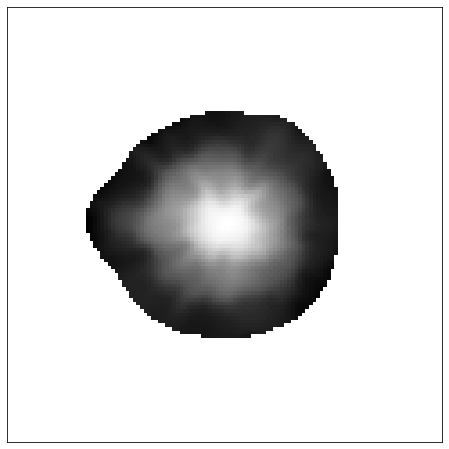

In [17]:
display_single(img, scale='linear', cmap='Greys_r');

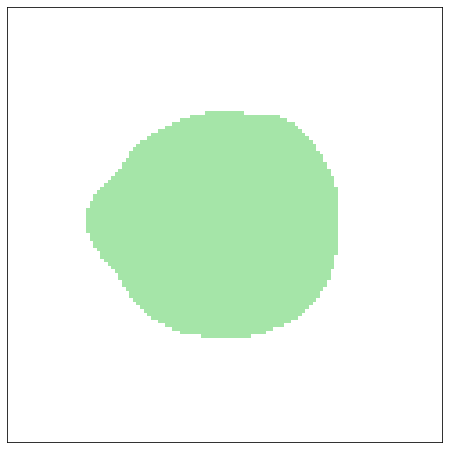

In [18]:
display_single(segmap.astype(float), cmap=SEG_CMAP, scale='linear');

In [19]:
# segmap = np.ones_like(img)

In [29]:
source_morphs = statmorph.source_morphology(
    img, segmap, weightmap=np.sqrt(weights[filt]),
    n_sigma_outlier=15, min_cutout_size=min_cutout_size, cutout_extent=2,
    mask=mask, psf=psfs[filt])
morph = source_morphs[0]

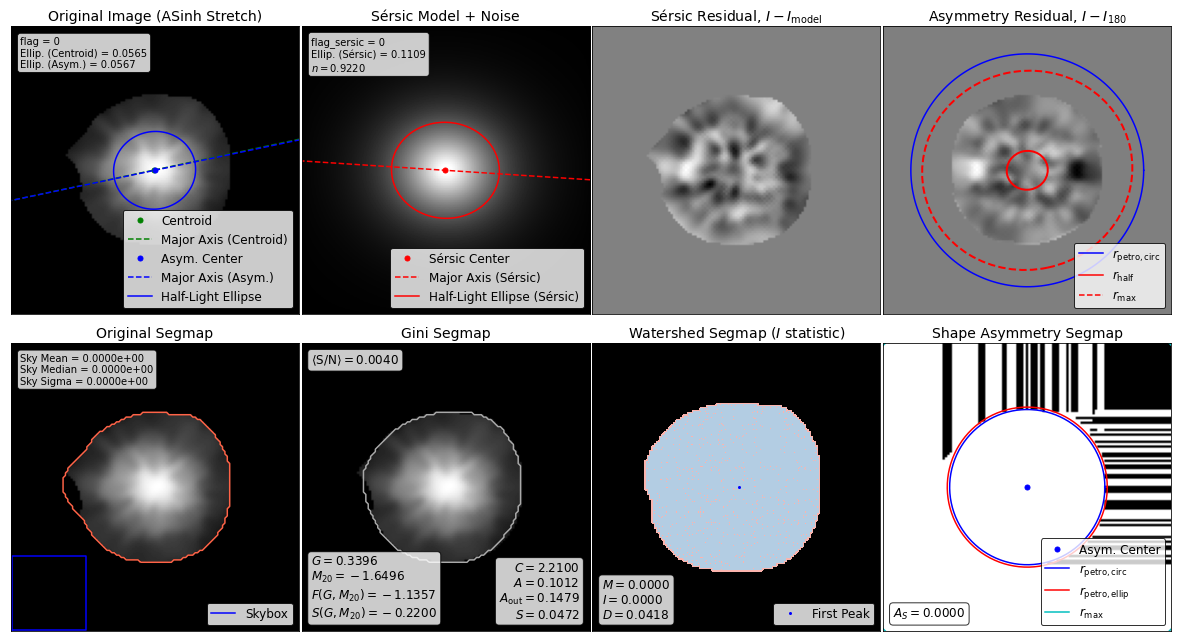

In [30]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph, asinh_a=0.8)

### Try the overall function

In [41]:
with open(f"./Model/NSA/z002_004/nsa-{lsbg['viz-id']}-trained-model-vanilla.df", "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

In [42]:
from kuaizi.measure import makeMeasurement

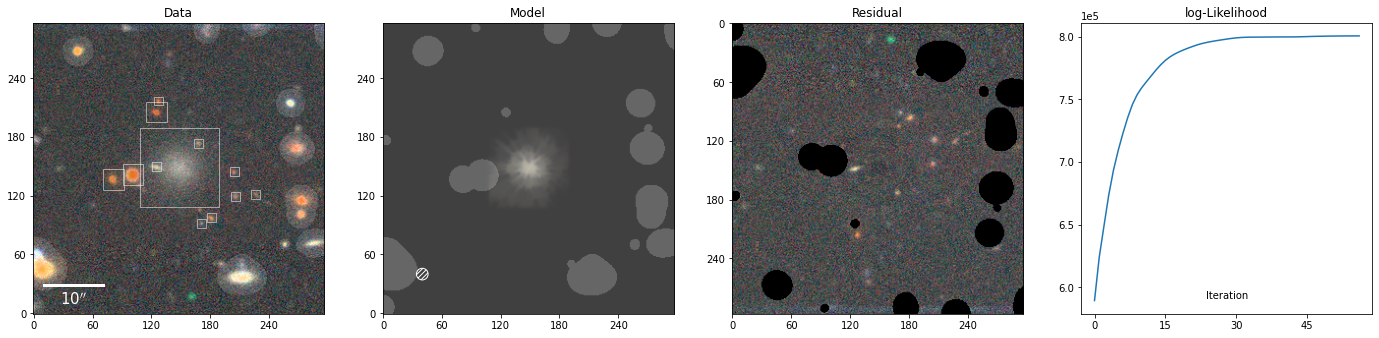

In [43]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            mask,
            show_ind=info['sed_ind'],
            zoomin_size=50,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=blend.observations[0].channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

CPU times: user 1.59 s, sys: 243 ms, total: 1.84 s
Wall time: 1.5 s


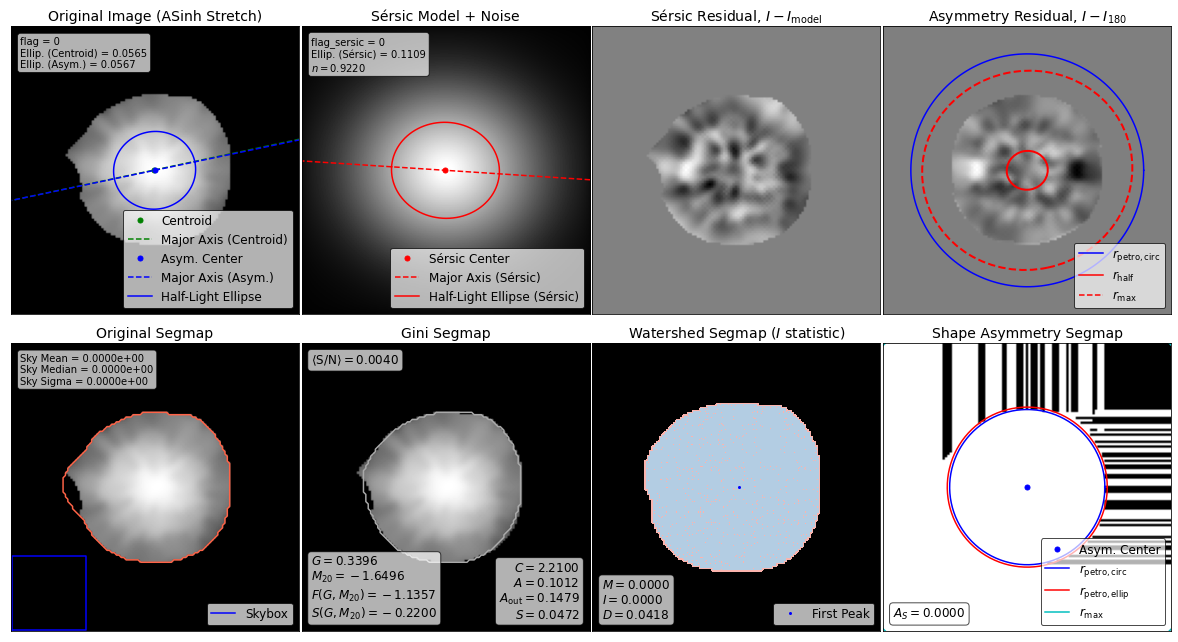

In [44]:
%%time
measurement, morph = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                                blend.observations[0], 
                                                aggr_mask=mask.astype(bool), 
                                                makesegmap=True, sigma=1,
                                                zeropoint=27.0, out_prefix=None, 
                                                show_fig=True, framealpha=0.7)

In [207]:
# wrap-up function
from diezi.scarlet_modeling.nsa_z002_004.vanilla_measure_all import measure_vanilla, initialize_meas_cat
meas_cat = initialize_meas_cat(lsbg_cat)
measure_vanilla(5, lsbg_cat, meas_cat, model_dir='./Model/NSA/z002_004/')

ID,flux [4],mag [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1719.0,29.080238342285156 .. 82.87366485595703,23.341005325317383 .. 22.20395851135254,24.77798080444336 .. 23.640933990478516,25.987525939941406 .. 24.850479125976562,25.919254302978516 .. 24.782207489013672,28.111883140465473,34.158475107219516,32.76791378560503,24.108951636213398,0.39693110813389465,0.45163082481974604,0.34839354006703244,-1.1135097791379243,12.985403807178272,15.894720303299065,9.493762362092223,12.977578407733409,17.7932173736575,0.7324106925274365,-1.3878705500518445,0.6272272191967394,0.20517257914495574,1.3640806384927466,-99.0,-4.828810755583645,1.005600004671997,0.07187976681587203,1.0,15.894720303299065,0.45163082481974604,2.0280828744518686,32.76791378560503,24.108951636213398,0.029116186505182336,1.0,1.0
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
